<a href="https://colab.research.google.com/github/AsifKarimShaik/AsifKarimShaik/blob/main/0_DTC_fromScratch_Tennis_BinarySplits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classification (from scratch)
-------------------------------
**Dr. Dave Wanik - University of Connecticut**

We can take everything that we have learned about decision trees for regression (with numeric targets) and generalize it to classification problems. The main concepts here have to deal with the 'optimality' or 'purity' of the split.



# Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# #Mount Drive
# from google.colab import drive
# drive.mount('/content/drive/')


# A Simple Example of Classification
Here is a very simple example of a decision tree. Depending on your age, salary and number of children - you may or may not be eligible to receive a loan. You can go to the regression example to read more on terminology and theory behind decisions.

<center>

![classification-tree.png](https://eloquentarduino.github.io/wp-content/uploads/2020/08/DecisionTree.png)

**PS** [check this link](https://eloquentarduino.github.io/2020/10/decision-tree-random-forest-and-xgboost-on-arduino/) to read about TinyML on sensors! Too cool.

# Some Math and Theory
Looking at the simple example above... the main question is why your 'Age' was chosen as the first decision level.

The answer is that the amount of **Information Gain** that is resolved by this decision is higher that the other decisions. We want to **maximize information gain** and **decrease randomness**... this sounds plausible, right? We want to choose the split that best partitions data into groups.

The way we maximize information gain is a function of how we measure **purity** in the nodes. This can either be quantified using information **entropy** or **Gini** which are just measures of randomness.

Higher entropy or gini means higher randomness (*bad!*) - a reduction in randomness means that things are more similar (*good!*). All of this should sound familiar to our regression example where we tried to lower the global standard deviation in the leaves!!! Tree-based modeling is just about finding pure splits that limit the noise in the prediction - we are looking for optimal splits to partition our data.




# A Simple Example (with gumballs!)
I found/stole this example with gumballs off of a [great blog](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb) that covers the difference between entropy and gini. Check it out for more examples.

When thinking about splits with categorical data (like sorting red and blue gumballs based on size or shinyness and other attributes), you may result with the following three candidate splits - which should you choose?  

* **Option 1:** If we have 4 red gumballs and 0 blue gumballs, that group of 4 is 100% pure.
* **Option 2:** If we have 2 red and 2 blue, that group is 100% impure.
* **Option 3:** If we have 3 red and 1 blue, that group is either 75% or 81% pure, if we use Gini or Entropy respectively.
  *  What are these quantities, Gini and entropy?! We will explain in a minute.

But if you had to choose a split, you would choose Option 1! This is because the split is pure. It's all red gumballs, no mixing and matching. A nice pure split.

## Entropy vs. Gini
What's the difference between entropy and gini? They both are quantities for measuring randomness but they do it differently - which means you can actually build two completely different decision trees depending on which metric you select! The trees probably will have very similar accuracy, but the rules will be different.  

## Which one should I use?
Which one should I use as my split criterion in the DTC model? Either one! Both are just fine choices when model - entropy does have a logarithm in the formula so it takes a little longer to run but this shouldn't turn you off from using it. Let's look at the formulas and check out some examples.

# Comparing Split Criterion
Let's keep using the gumball example.

![gumballs](https://www.ohnuts.com/noapp/showImage.cfm/zoom/Patriotic%20Gumballs2.jpg)

## Entropy

Information **entropy** is the average rate at which information is produced by a stochastic source of data. The formula for entropy is given by:

$\text{Entropy}$ $=$ $-\sum_{i=1}^{n} P_i\times Log_b(P_i)$

where:
* $n$ is the number of gumballs that your are sorting, in our case, red or blue. So $n=2$.
* $P_i$ is the gumball color of choice, red or blue. You'll look at the purity of red first, then blue. Remember that entropy will be a function of the purity of the node - which is a function of how many blue and red gumballs there are. See below for example.

You can use any log you want - we will use a log2 for consistency.

In [ ]:
x = 0.00001
print(np.log2(x))

-16.609640474436812


In [ ]:
x = 0.001
print(np.log2(x))

-9.965784284662087


In [ ]:
x = 1
print(np.log2(x)) # so if there is no randomness, there is no entropy! this makes sense

0.0


In [ ]:
x = 0
print(np.log2(x)) # infinite - undefined - we assume it is 0 but won't recode it

-inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


### 4 red, 0 blue
* We can think of this as 100% pure.
* Be careful of where the negative sign goes or the math won't work out!
* The negative sign goes in front front of the sum


Here is the math:
* Entropy = -[p(Red)$\times$log(p(Red))] - [p(Blue)$\times$log(p(Blue))]
* Entropy = -[(4/4)$\times$log(4/4)] - [(0/4)$\times$log(0/4)]
* Entropy = 0

Remember, log(0) is  equal to 0 and log(1) is also equal to 0. So, a perfect split has resulted in an entropy of 0

In [ ]:
# if you tried to take np.log(0/4), you would get a NaN -
# it's not worth adding logic right now to correct this!
# see here for more log rules: http://www.mclph.umn.edu/mathrefresh/logs3.html

#
pRed = 4/4
pBlue = 0/4

Entropy = -pRed*np.log2(pRed) #- pBlue*np.log2(pBlue)
print(Entropy)

-0.0


We just commented out the log(0) because it is undefined.

### 2 red, 2 blue
Pure randomness/random guess has an entropy of 1!

In [ ]:
# 2 red and 2 blue
pRed = 2/4
pBlue = 2/4

Entropy = -pRed*np.log2(pRed) - pBlue*np.log2(pBlue)
print(Entropy)

# so! Entropy equals 1 when it is pure randomness!

1.0


### 3 red, 1 blue


In [ ]:
# 3 red and 1 blue
pRed = 3/4
pBlue = 1/4

Entropy = -pRed*np.log2(pRed) - pBlue*np.log2(pBlue)
print(Entropy)

0.8112781244591328


### Summary
We see that entropy takes on values between 0 and 1:
* values closer to 0 indicate a perfect split (no randomness)
* values closer to 1 indicate pure randomness

Be careful of log 0.

## Gini
In your studies of data science, you may also come across **Gini**. Gini and entropy are closely related.

$\text{Gini} = 1 - \sum_{i=1}^{n}P_i^2$

Gini varies takes on values between 0 and 0.5. There are no logarithms here!

### 4 red, 0 blue

In [ ]:
pRed = 4/4
pBlue = 0/4
Gini = 1 - (pRed**2 + pBlue**2)
print(Gini)

0.0


In [ ]:
# 4 red balls and 0 blue
'''
We can think of this as 100% pure

Gini = 1 - (p(Red)^2 + p(Blue)^2)
Gini = 1 - (1 + 0)
Gini = 0

this means that it is a perfect split, Gini is 0.
so when Gini is 0, it's a perfect split.
it is the most pure score possible.

decision trees are all about purity... they want
to find PERFECT SPLITS that minimize the gini.

a decision tree is trying its best to make decisions that minimizes gini (randomness)!

'''

"\nWe can think of this as 100% pure\n\nGini = 1 - (p(Red)^2 + p(Blue)^2)\nGini = 1 - (1 + 0)\nGini = 0\n\nthis means that it is a perfect split, Gini is 0.\nso when Gini is 0, it's a perfect split.\nit is the most pure score possible.\n\ndecision trees are all about purity... they want \nto find PERFECT SPLITS that minimize the gini. \n\na decision tree is trying its best to make decisions that minimizes gini (randomness)!\n\n"

### 2 red, 2 blue

In [ ]:
pRed = 2/4
pBlue = 2/4
Gini = 1 - (pRed**2 + pBlue**2)
print(Gini)

0.5


In [ ]:
# 2 red and 2 blue
'''
We can think of this as 100% random or 0% pure
a 50/50 split is not useful! there's no skill here.

Gini = 1 - (p(red)^2 + p(blue)^2)
Gini = 1 - (0.5^2 + 0.5^2)
Gini = 0.5

so, when your split has no skill, you get a gini of 0.5

'''

"\nWe can think of this as 100% random or 0% pure\na 50/50 split is not useful! there's no skill here.\n\nGini = 1 - (p(red)^2 + p(blue)^2)\nGini = 1 - (0.5^2 + 0.5^2)\nGini = 0.5\n\nso, when your split has no skill, you get a gini of 0.5\n\n"

### 3 red, 1 blue

In [ ]:
pRed = 3/4
pBlue = 1/4
Gini = 1 - (pRed**2 + pBlue**2)
print(Gini)

0.375


In [ ]:
# 3 red and 1 blue
'''
Somewhere in the middle

Gini = 1 - (p(red)^2 + p(blue)^2)
Gini = 1 - ((3/4)^2 + (1/4)^2)
Gini = 1 - (0.75^2 + 0.25^2)
Gini = 0.375

as can be imagined, it's tough to get a perfect split (gini=0),
and you don't want the random split (gini=0.5),
so you probably end up with a gini somewhere between 0 and 0.5...
you want to pick a gini closer to 0

so if you are looking at ALL POSSIBLE SPLITS...
choose the gini closest to 0.

'''

"\nSomewhere in the middle\n\nGini = 1 - (p(red)^2 + p(blue)^2)\nGini = 1 - ((3/4)^2 + (1/4)^2)\nGini = 1 - (0.75^2 + 0.25^2)\nGini = 0.375\n\nas can be imagined, it's tough to get a perfect split (gini=0),\nand you don't want the random split (gini=0.5),\nso you probably end up with a gini somewhere between 0 and 0.5...\nyou want to pick a gini closer to 0\n\nso if you are looking at ALL POSSIBLE SPLITS...\nchoose the gini closest to 0.\n\n"

# Information Gain
It's all about parent/child relationships - you want to decrease the noise as you go deeper and deeper into the tree. Your model should get better and better and decrease randomness (entropy) as you split - otherwise, why would you keep splitting? Your nodes will get purer and purer until all of the observations in the leaf are (essentially) the same!

* If your split results in a more accurate prediction, do it!
* If your split does not result in a more accurate prediction, don't do it!

Information gain is used to measure the effectiveness of an attribute in classifying the training data. i.e. the higher the information gain value of an attribute, the better it classifies the training data.

The Information Gain of a feature is calculated with:

* $\text{InfoGain}=\text{Entropy}(\text{Parent}) - \text{Entropy}(\text{Child})$
* $\text{InfoGain}=\text{Gini}(\text{Parent}) - \text{Gini}(\text{Child})$

Child entropy (or Gini) should never be bigger than parent entropy! You are always trying to decrease the randomness. You can use either metric for splitting, but you can't use both at once, of course!

# Why multiply Gini times two?
Why multiply two? Gini takes on values between 0 and 0.5! So in order to make a comparison with entropy, folks often will multiply Gini times 2. That's it.

![entropy vs. gini curve](https://quantdare.com/wp-content/uploads/2020/11/entropy_and_gini.png)

**Figure:** (left) gini and entropy with raw values, (right) gini times two and entropy.

In [ ]:
#Gini Function
#a and b are the quantities of each class
def gini(a,b):
    a1 = (a/(a+b))**2
    b1 = (b/(a+b))**2
    return 1 - (a1 + b1)

#Blank lists
gini_list = []
blue_list = []
red_list = []
blue_prob_list = []
#Looping Gini function on random blue and red float amounts
for x in range (100000):
 blue = np.round(np.random.uniform(0, 100),0) #my example is a little different
 red = np.abs(100-blue)
 a = gini(red,blue)
 b = blue/(blue+red)
 gini_list.append(a)
 blue_list.append(blue)
 red_list.append(red)
 blue_prob_list.append(b)
#Dataframe of amount of blue, red, Probability of blue, and gini score
df = pd.DataFrame({'Blue': blue_list, 'Red': red_list,'Gini Score': gini_list, 'Probability of Blue': blue_prob_list})
df = df[['Red', 'Blue', 'Probability of Blue', 'Gini Score']]

In [ ]:
df.head()

,Red,Blue,Probability of Blue,Gini Score
0,30.0,70.0,0.70,0.4200
1,46.0,54.0,0.54,0.4968
2,20.0,80.0,0.80,0.3200
3,71.0,29.0,0.29,0.4118
4,14.0,86.0,0.86,0.2408


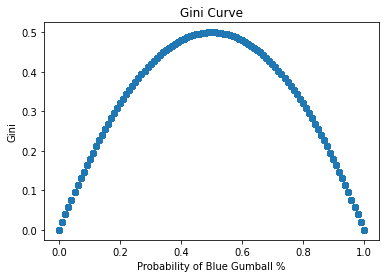

In [ ]:
# plot the curve
plt.scatter(blue_prob_list,gini_list)
plt.xlabel('Probability of Blue Gumball %')
plt.ylabel('Gini')
plt.title('Gini Curve')
plt.show()

# note how the curve is symmetric!

On your own, you are welcome to try to include the entropy here aso well! Good luck.

# Comparison of Entropy vs. Gini Trees
Figures are from this website: https://quantdare.com/decision-trees-gini-vs-entropy/

![gini tree](https://quantdare.com/wp-content/uploads/2020/11/gini_tree2.png)

**Figure:** A decision tree developed with 'Gini' as the split criterion.

![entropy tree](https://quantdare.com/wp-content/uploads/2020/11/entropy_tree2.png)

**Figure:** A decision tree developed with 'entropy' as the split criterion.


## Can you see the difference in tree splits?
Different variables and thresholds are used! Look at the lefthand side of the tree.

# Read data from a downloadable link

Here is a nice [StackOverflow post](https://stackoverflow.com/questions/65099766/is-there-a-way-to-download-data-from-a-public-link-to-google-colab) on how to import data from a shareable link. You are going to grab a file off of my Drive - you can mess around with the ID and try to download off of your Drive. Then benefit of this is that you don't need to mount your Drive - then downside is someone with the link will be able to download your data! Only do this for public/nonpropietary stuff. It's just a shortcut.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Data load
# df = pd.read_excel('/content/drive/MyDrive/tennis data regression.xlsx')

# https://drive.google.com/file/d/1atzInurzyy7AhfI-g5QdvheM1p7OqNO7/view?usp=sharing
!gdown 1atzInurzyy7AhfI-g5QdvheM1p7OqNO7
df = pd.read_excel('tennis binary classification.xlsx') # look left! it's in your local workspace

# see how we can hack the shareable link and download? NICE!
# LOOK LEFT and you will see it downloads locally... no path required

Downloading...
From: https://drive.google.com/uc?id=1atzInurzyy7AhfI-g5QdvheM1p7OqNO7
To: /content/tennis binary classification.xlsx
100% 54.7k/54.7k [00:00<00:00, 39.0MB/s]


In [ ]:
print(df.shape)
df.head()

(14, 6)


,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
4,5.0,Rain,Cool,Normal,Weak,yes


In [ ]:
def entropy_calculate(prob_list):

    entropy = 0
    for item in prob_list:
        entropy -= item * np.log2(item)
    return entropy

In [ ]:
df

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
7,8.0,Sunny,Hot,High,Weak,no
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes


In [ ]:
df['play'].value_counts()

yes    9
no     5
Name: play, dtype: int64

BTW - you can use any base logarithm - the math will still work out. We use base2 for this notebook.

# Build the Model!
We will use **entropy** as our split criterion for example purposes. On your own, you are welcome to code your own notebook with Gini as the split criterion. Do you get the same tree? Perhaps not!

## Entropy of the entire system  ($E = 0.94, n=14$)

Entropy of the entire system, $E$: 14 observations: 9 Yes and 5 No = 0.94

In [ ]:
cases,counts = np.unique(df['play'] ,return_counts=True)
P = [count/len(df) for count in counts]
print('Probabilities of %s and %s are %.3f, %.3f respectively'%(cases[0],cases[1],P[0],P[1]))

entropy_entire = entropy_calculate(P)

print('Entire system entropy, E, is %.3f bits'%entropy_entire)

Probabilities of no and yes are 0.357, 0.643 respectively
Entire system entropy, E, is 0.940 bits


In [ ]:
# here it is the simple way
tmp = -(9/14)*np.log2(9/14) - (5/14)*np.log2(5/14)
tmp

0.9402859586706309

# The first split candidates
To determine the best split, we will go through all of the columns one by one. For each column, we look at all the possible options for splitting.

We will consider:
* **`Outlook`** - has two different categories for splitting (sunny, rainy)
* **`Temperature`** - has two categories for splitting (hot, cool)
* **`Humidity`** - has two categories for splitting (normal, high)
* **`Wind`** - has two categories for splitting (strong, weak)

This means that there are many possible options for splitting - YIKES! We will tackle these one by one and try to stay organized.


Different from regression problem, our goal is to calculate`entropy` for each decision. For each decision, entropy is calculated for each case under that decision and meanwhile `information gain` is calculated.

## Outlook

### Sunny ($\epsilon = 0.97,n=5$)

In [ ]:
### sunny
sunny = df.loc[df.Outlook == 'Sunny']
sunny

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
7,8.0,Sunny,Hot,High,Weak,no
8,9.0,Sunny,Cool,Normal,Weak,yes
10,11.0,Sunny,Cool,Normal,Strong,yes


In [ ]:
cases,counts = np.unique(sunny.play,return_counts=True)
print('cases:', cases)
print('counts:', counts)
P_sunny = [count/len(sunny) for count in counts]
print('P_sunny:', P_sunny)
entropy_sunny = entropy_calculate(P_sunny)

print('Sunny entropy is %.3f bits'%entropy_sunny)

cases: ['no' 'yes']
counts: [3 2]
P_sunny: [0.6, 0.4]
Sunny entropy is 0.971 bits


### Rainy ($\epsilon = 0.76,n=9$)

In [ ]:
### rainy
rainy = df.loc[df.Outlook == 'Rain']
rainy

,Day,Outlook,Temp,Humidity,Wind,play
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
9,10.0,Rain,Cool,Normal,Weak,yes
11,12.0,Rain,Cool,High,Strong,yes
12,13.0,Rain,Hot,Normal,Weak,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(rainy.play,return_counts=True)
P_rainy = [count/len(rainy) for count in counts]

entropy_rainy = entropy_calculate(P_rainy)

print('Rainy entropy is %.3f bits'%entropy_rainy)

Rainy entropy is 0.764 bits


### Summary ($\text{IG} = 0.105$)

In [ ]:
#total_entropy_Outlook
total_entropy_outlook = 0.97*(5/14)+0.76*(9/14)
print(total_entropy_outlook)

# information Gain
infogain = entropy_entire- total_entropy_outlook
infogain

0.835


0.10528595867063095

## Temperature

### Hot ($\epsilon = 0.97,n=5$)

In [ ]:
# Hot temperature
hot = df.loc[df['Temp'] == 'Hot']
hot

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
2,3.0,Rain,Hot,High,Weak,yes
7,8.0,Sunny,Hot,High,Weak,no
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(hot.play,return_counts=True)
P_hot = [count/len(hot) for count in counts]

entropy_hot = entropy_calculate(P_hot)

print('Hot entropy is %.3f bits'%entropy_hot)

Hot entropy is 0.971 bits


### Cool ($\epsilon = 0.76,n=9$)

In [ ]:
# cool temperature
cool = df.loc[df['Temp'] == 'Cool']
cool

,Day,Outlook,Temp,Humidity,Wind,play
3,4.0,Rain,Cool,High,Weak,yes
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes
10,11.0,Sunny,Cool,Normal,Strong,yes
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(cool.play,return_counts=True)
P_cool = [count/len(cool) for count in counts]

entropy_cool = entropy_calculate(P_cool)

print('Cool entropy is %.3f bits'%entropy_cool)

Cool entropy is 0.764 bits


### Summary ($\text{IG} = 0.105$)

In [ ]:
#total_entropy_temperature
total_entropy_temperature = 0.97*(5/14)+0.76*(9/14)

# information Gain
infogain = entropy_entire- total_entropy_temperature
infogain

0.10528595867063095

## Wind

###Strong wind ($\epsilon = 1.0, n=6$)

In [ ]:
# strong wind
strong = df.loc[df['Wind'] == 'Strong']
strong

,Day,Outlook,Temp,Humidity,Wind,play
1,2.0,Sunny,Hot,High,Strong,no
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
10,11.0,Sunny,Cool,Normal,Strong,yes
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(strong.play,return_counts=True)
P_strong = [count/len(strong) for count in counts]

entropy_strong = entropy_calculate(P_strong)

print('Strong entropy is %.3f bits'%entropy_strong)

Strong entropy is 1.000 bits


###Weak wind ($\epsilon = 0.81,n=8$)

In [ ]:
# weak wind
weak = df.loc[df['Wind'] == 'Weak']
weak

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
4,5.0,Rain,Cool,Normal,Weak,yes
7,8.0,Sunny,Hot,High,Weak,no
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(weak.play,return_counts=True)
P_weak = [count/len(weak) for count in counts]

entropy_weak = entropy_calculate(P_weak)

print('Weak entropy is %.3f bits'%entropy_weak)

Weak entropy is 0.811 bits


### Summary ($\text{IG} = 0.049$)

In [ ]:
#total_entropy_wind
total_entropy_wind = 1*(6/14)+0.81*(8/14)

# information Gain
infogain = entropy_entire- total_entropy_wind
infogain

0.04885738724205946

## Humidity

### Normal ($\epsilon = 0.59, n=7$)

In [ ]:
# normal humidity
normal = df.loc[df['Humidity'] == 'Normal']
normal

,Day,Outlook,Temp,Humidity,Wind,play
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes
10,11.0,Sunny,Cool,Normal,Strong,yes
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(normal.play,return_counts=True)
P_normal = [count/len(normal) for count in counts]

entropy_normal = entropy_calculate(P_normal)

print('Normal entropy is %.3f bits'%entropy_normal)

Normal entropy is 0.592 bits


### High ($\epsilon = 0.99. n=7$)

In [ ]:
# high humidity
high = df.loc[df['Humidity'] == 'High']
high

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
7,8.0,Sunny,Hot,High,Weak,no
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(high.play,return_counts=True)
P_high = [count/len(high) for count in counts]

entropy_high = entropy_calculate(P_high)

print('High entropy is %.3f bits'%entropy_high)

High entropy is 0.985 bits


### Summary ($\text{IG} = 0.15$)

In [ ]:
#total_entropy_humidity
total_entropy_humidity = 0.59*(7/14)+0.99*(7/14)

# information Gain
infogain = entropy_entire- total_entropy_humidity
infogain

0.15028595867063088

# And the first split is... `Humidity`!
Why `Humidity`? It has the largest Information Gain, $\epsilon = 0.15$.

So this tells us it is the best candidate to split the data.

### Visualization of the first-split tree
As shown above, by choosing humidity as the first decision/question, the highest reduction in entropy/randomness is achieved that corresponds to the highest Information Gain

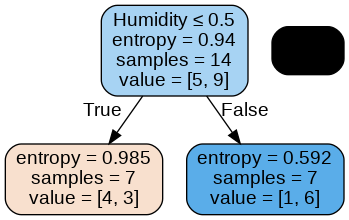

In [ ]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

df['Outlook'] = Le.fit_transform(df['Outlook'])
df['Temp'] = Le.fit_transform(df['Temp'])
df['Humidity'] = Le.fit_transform(df['Humidity'])
df['Wind'] = Le.fit_transform(df['Wind'])
df['play'] = Le.fit_transform(df['play'])

y = df['play']
X = df[['Outlook','Temp','Humidity','Wind']]

# Fitting the model
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy',max_leaf_nodes=2)
clf = clf.fit(X, y)

from sklearn.tree import export_graphviz
from six import StringIO #updated
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf,  # this is the name of your model!
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Left vs. Right Split
Remember, now global entropy is relative to the parent, so we will need to calculate for both left and right nodes.

# Left leaf: `Humidity == High` ($E = 0.99$, $n=7$)
DO NOT FORGET TO UPDATE THE ENTROPY OF THE ENTIRE SYSTEM - it is relative to this leaf!

In [ ]:
# entropy_entire
entropy_entire = entropy_high
print(entropy_entire)

0.9852281360342515


##Outlook

### Sunny ($\epsilon = 0.0$, $n=3$)

In [ ]:
# sunny outlook when humidity is high
sunny = high.loc[high['Outlook'] == 'Sunny']
sunny

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
7,8.0,Sunny,Hot,High,Weak,no


In [ ]:
cases,counts = np.unique(sunny.play,return_counts=True)
P_sunny = [count/len(sunny) for count in counts]

entropy_sunny = entropy_calculate(P_sunny)

print('Sunny entropy is %.3f bits'%entropy_sunny)

Sunny entropy is 0.000 bits


### Rainy ($\epsilon = 0.81$, $n=4$)

In [ ]:
# rainy outlook when humidity is high
rainy = high.loc[high['Outlook'] == 'Rain']
rainy

,Day,Outlook,Temp,Humidity,Wind,play
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(rainy.play,return_counts=True)
P_rainy = [count/len(rainy) for count in counts]

entropy_rainy = entropy_calculate(P_rainy)

print('rainy entropy is %.3f bits'%entropy_rainy)

rainy entropy is 0.811 bits


### Summary ($\text{IG} = 0.52$)

In [ ]:
#total_entropy_outlook
total_entropy_outlook = 0.0*(3/7)+0.81*(4/7)

# information Gain
infogain = entropy_entire- total_entropy_outlook
infogain

0.5223709931771087

##Temperature

### Hot ($\epsilon = 0.81, n= 4$)

In [ ]:
# hot when humidity is high
hot = high.loc[high['Temp'] == 'Hot']
hot

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
1,2.0,Sunny,Hot,High,Strong,no
2,3.0,Rain,Hot,High,Weak,yes
7,8.0,Sunny,Hot,High,Weak,no


In [ ]:
cases,counts = np.unique(hot.play,return_counts=True)
P= [count/len(hot) for count in counts]

entropy = entropy_calculate(P)

print('Hot entropy is %.3f bits'%entropy)

Hot entropy is 0.811 bits


### Cool ($\epsilon = 0.92, n= 3$)

In [ ]:
# cool when humidity is high
cool = high.loc[high['Temp'] == 'Cool']
cool

,Day,Outlook,Temp,Humidity,Wind,play
3,4.0,Rain,Cool,High,Weak,yes
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(cool.play,return_counts=True)
P= [count/len(cool) for count in counts]

entropy = entropy_calculate(P)

print('Cool entropy is %.3f bits'%entropy)

Cool entropy is 0.918 bits


### Summary ($\text{IG} = 0.12$)

In [ ]:
#total_entropy_temp
total_entropy_temperature = 0.81*(4/7)+0.92*(3/7)

# information Gain
infogain = entropy_entire- total_entropy_temperature
infogain

0.12808527889139432

## Wind

### Strong ($\epsilon = 0.92, n= 3$)

In [ ]:
# strong wind when humidity is high
strong = high.loc[high['Wind'] == 'Strong']
strong

,Day,Outlook,Temp,Humidity,Wind,play
1,2.0,Sunny,Hot,High,Strong,no
11,12.0,Rain,Cool,High,Strong,yes
13,14.0,Rain,Cool,High,Strong,no


In [ ]:
cases,counts = np.unique(strong.play,return_counts=True)
P= [count/len(strong) for count in counts]

entropy = entropy_calculate(P)

print('Strong wind entropy is %.3f bits'%entropy)

Strong wind entropy is 0.918 bits


### Weak ($\epsilon = 1.0, n= 4$)

In [ ]:
# weak wind when humidity is high
weak = high.loc[high['Wind'] == 'Weak']
weak

,Day,Outlook,Temp,Humidity,Wind,play
0,1.0,Sunny,Hot,High,Weak,no
2,3.0,Rain,Hot,High,Weak,yes
3,4.0,Rain,Cool,High,Weak,yes
7,8.0,Sunny,Hot,High,Weak,no


In [ ]:
cases,counts = np.unique(weak.play,return_counts=True)
P= [count/len(weak) for count in counts]

entropy = entropy_calculate(P)

print('Weak wind entropy is %.3f bits'%entropy)

Weak wind entropy is 1.000 bits


### Summary ($\text{IG} = 0.19$)

In [ ]:
#total_entropy_wind
total_entropy_wind = 0.92*(3/7)+1*(4/7)

# information Gain
infogain = entropy_entire- total_entropy_wind
infogain

0.019513850319965775

# And the second left split is... `Outlook`!
Why `Outlook`? It has the largest Information Gain, $\epsilon = 0.52$.

So this tells us it is the best candidate to split the data. We will see a visualization a little bit later on.

# Right leaf: `Humidity == Normal` ($E = 0.59$, $n=7$)
DO NOT FORGET TO UPDATE THE ENTROPY OF THE ENTIRE SYSTEM - it is relative to this leaf!

In [ ]:
# entropy_entire
entropy_entire = entropy_normal
print(entropy_entire)

0.5916727785823275


## Outlook

### Sunny ($\epsilon = 0.0$, $n=2$)

In [ ]:
# sunny outlook when humidity is normal
sunny = normal.loc[normal['Outlook'] == 'Sunny']
sunny

,Day,Outlook,Temp,Humidity,Wind,play
8,9.0,Sunny,Cool,Normal,Weak,yes
10,11.0,Sunny,Cool,Normal,Strong,yes


In [ ]:
cases,counts = np.unique(sunny.play,return_counts=True)
P_sunny = [count/len(sunny) for count in counts]

entropy_sunny = entropy_calculate(P_sunny)

print('Sunny entropy is %.3f bits'%entropy_sunny)

Sunny entropy is 0.000 bits


### Rainy ($\epsilon = 0.72$, $n=5$)

In [ ]:
# rainy outlook when humidity is normal
rainy = normal.loc[normal['Outlook'] == 'Rain']
rainy

,Day,Outlook,Temp,Humidity,Wind,play
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
9,10.0,Rain,Cool,Normal,Weak,yes
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(rainy.play,return_counts=True)
P_rainy = [count/len(rainy) for count in counts]

entropy_rainy = entropy_calculate(P_rainy)

print('rainy entropy is %.3f bits'%entropy_rainy)

rainy entropy is 0.722 bits


### Summary ($\text{IG} = 0.08$)

In [ ]:
#total_entropy_outlook
total_entropy_outlook = 0*(2/7)+0.72*(5/7)

# information Gain
infogain = entropy_entire- total_entropy_outlook
infogain

0.07738706429661324

##Temperature

### Hot ($\epsilon = 0.0, n= 1$)

In [ ]:
# hot when humidity is normal
hot = normal.loc[normal['Temp'] == 'Hot']
hot

,Day,Outlook,Temp,Humidity,Wind,play
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(hot.play,return_counts=True)
P= [count/len(hot) for count in counts]

entropy = entropy_calculate(P)

print('Hot entropy is %.3f bits'%entropy)

Hot entropy is 0.000 bits


### Cool ($\epsilon = 0.65, n= 6$)

In [ ]:
# cool when humidity is high
cool = normal.loc[normal['Temp'] == 'Cool']
cool

,Day,Outlook,Temp,Humidity,Wind,play
4,5.0,Rain,Cool,Normal,Weak,yes
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes
10,11.0,Sunny,Cool,Normal,Strong,yes


In [ ]:
cases,counts = np.unique(cool.play,return_counts=True)
P= [count/len(cool) for count in counts]

entropy = entropy_calculate(P)

print('Cool entropy is %.3f bits'%entropy)

Cool entropy is 0.650 bits


### Summary ($\text{IG} = 0.04$)

In [ ]:
#total_entropy_temp
total_entropy_temperature = 0.0*(1/7)+0.65*(6/7)

# information Gain
infogain = entropy_entire- total_entropy_temperature
infogain

0.03452992143947031

## Wind

### Strong ($\epsilon = 0.92, n= 3$)

In [ ]:
# strong wind when humidity is normal
strong = normal.loc[normal['Wind'] == 'Strong']
strong

,Day,Outlook,Temp,Humidity,Wind,play
5,6.0,Rain,Cool,Normal,Strong,no
6,7.0,Rain,Cool,Normal,Strong,yes
10,11.0,Sunny,Cool,Normal,Strong,yes


In [ ]:
cases,counts = np.unique(strong.play,return_counts=True)
P= [count/len(strong) for count in counts]

entropy = entropy_calculate(P)

print('Strong wind entropy is %.3f bits'%entropy)

Strong wind entropy is 0.918 bits


### Weak ($\epsilon = 0.0, n= 4$)

In [ ]:
# weak wind when humidity is high
weak = normal.loc[normal['Wind'] == 'Weak']
weak

,Day,Outlook,Temp,Humidity,Wind,play
4,5.0,Rain,Cool,Normal,Weak,yes
8,9.0,Sunny,Cool,Normal,Weak,yes
9,10.0,Rain,Cool,Normal,Weak,yes
12,13.0,Rain,Hot,Normal,Weak,yes


In [ ]:
cases,counts = np.unique(weak.play,return_counts=True)
P= [count/len(weak) for count in counts]

entropy = entropy_calculate(P)

print('Weak wind entropy is %.3f bits'%entropy)

Weak wind entropy is 0.000 bits


### Summary ($\text{IG} = 0.19$)

In [ ]:
#total_entropy_Wind
total_entropy_wind = 0.92*(3/7)+0*(4/7)

# information Gain
infogain = entropy_entire- total_entropy_wind
infogain

0.19738706429661318

# And the second right split is... `Wind`!
Why `Wind`? It has the largest Information Gain, $\epsilon = 0.55$.

So this tells us it is the best candidate to split the data.

## Visualization of the second-split tree

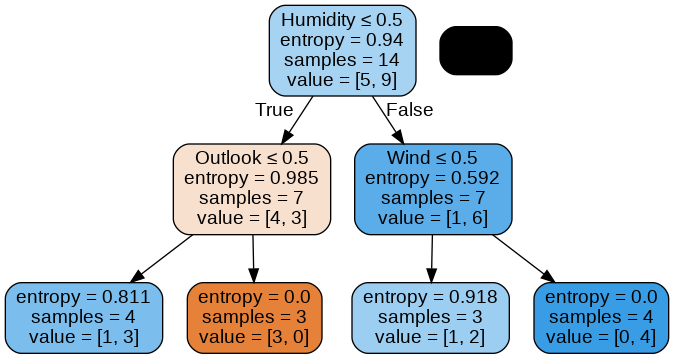

In [ ]:
# Fitting the model
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy',min_samples_leaf=3)
clf = clf.fit(X, y)

# show the tree
# link: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
from sklearn.tree import export_graphviz
from six import StringIO # updated
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf,  # this is the name of your model!
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())



# Part 2: DecisionTreeClassifier() from `sklearn`

Let's develop the model to see if they match out calculation

In [ ]:
# import module
from sklearn.tree import DecisionTreeClassifier

## Model

In [ ]:
# Recode the data
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

df['Outlook'] = Le.fit_transform(df['Outlook'])
df['Temp'] = Le.fit_transform(df['Temp'])
df['Humidity'] = Le.fit_transform(df['Humidity'])
df['Wind'] = Le.fit_transform(df['Wind'])
df['play'] = Le.fit_transform(df['play'])

In [ ]:
y = df['play']
X = df[['Outlook','Temp','Humidity','Wind']]

# Fitting the model
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy') # we have not tweaked any hyperparameters!
clf = clf.fit(X, y)

## Visualization

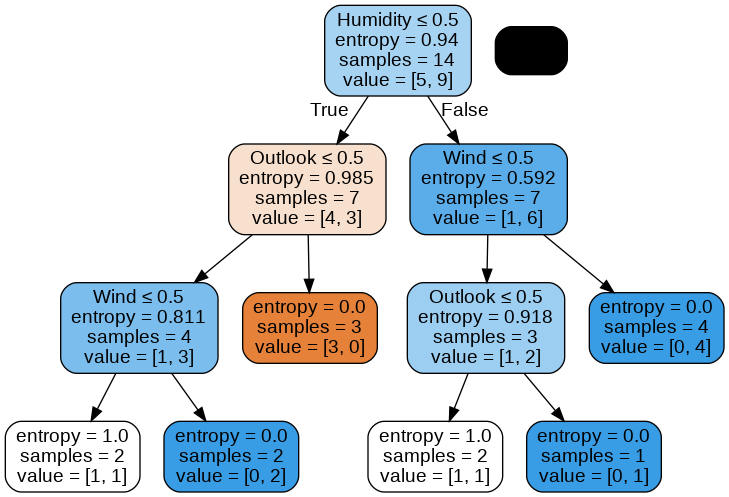

In [ ]:
# show tree
from sklearn.tree import export_graphviz
from six import StringIO # updated
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf,  # this is the name of your model!
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## (Optional)Hyperparameters
***Here is a list of the hyperparameters in sklearn for the DecisionTreeClassifier:***

**criterion:**`{“gini”, “entropy”}, default=”gini”`

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth:** `int, default=None`

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split:** `int or float, default=2`

The minimum number of samples required to split an internal node

**min_samples_leaf:** `int or float, default=1`

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

**max_leaf_nodes:** `int, default=None`
Grow a tree with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

**max_features:** `int, float or {“auto”, “sqrt”, “log2”}, default=None`

The number of features to consider when looking for the best split:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {"criterion": ['gini', 'entropy'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

## Comment in order to publish in kaggle.

grid_cv_DTC = GridSearchCV(clf, param_grid, cv=5)

grid_cv_DTC.fit(X,y)

print("Accuracy::{}".format(grid_cv_DTC.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_DTC.best_params_))

Accuracy::0.6333333333333333
Best Hyperparameters::
{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}
